<a href="https://colab.research.google.com/github/lmurtinho/CodeChallengeFallDetection/blob/main/notebooks/Prosigliere_Code_Challenge_Fall_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prosigliere Coding Challenge: Fall Detection

This Google Colab notebook presents my solution to the Prosigliere Coding Challenge, the full description of which can be found [here](https://github.com/Prosigliere/coding-challenges/blob/main/AI_ML_Challenge.md). The main goal of the challenge is to predict, based on body sensor data, whether a fall took place during a trial. The data set is composed of 480 trials, with 8 subjects performing an average of 60 trials each.

## Data Loading and Preprocessing

The first task is to load and process the data. According to the project's description, the full dataset (which can be found [here](https://drive.google.com/drive/folders/1Rr5eI8btUAKqDjmDc2vxRyu0C0yRX1Xl)) is thus organized:

- Each folder in the root directory corresponds to a subject.
- Each subfolder in a subject folder corresponds to a type of trial: `ADLs`, `Falls`, and `Near_Falls`.
- Each file (`.xlsx`) contains sensor data for a single trial.

I saved the files in a folder on my Google Drive, so the first step is to mount the drive and define the data location. I also added a folder to cache the prepared data to avoid reprocessing the raw files.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ROOT = '/content/drive/My Drive/prosigliere_challenge'
data_path = f'{ROOT}/data'
cache_dir = f'{data_path}/cached'

Mounted at /content/drive


### Data Loading

The `load_data` function below recursively finds all `.xslx` files in the data folder path of `subject/type_of_trial` and stores them in the `all_trials` dict along with some metadata (including the subject id and the trial type).

In [2]:
import os
import glob
import pandas as pd
from tqdm import tqdm


def load_data(data_path):
  """
  Load and organize sensor data from Excel files by trials.
  Args:
      data_path: The path to the root directory containing subject folders.
  Returns:
      A list of dictionaries, where each dictionary represents a trial
      and contains the sensor data (as a pandas DataFrame) along with
      metadata like subject ID, trial type, file name, and file path.
  Raises:
      ValueError: If no subject folders are found in the specified data_path.
  """
  print("Loading trial-based data...")
  all_trials = []

  # Get all subject folders
  subject_folders = glob.glob(os.path.join(data_path, 'sub*'))

  if not subject_folders:
      raise ValueError(f"No subject folders found in {data_path}")

  for subject_folder in subject_folders:
      subject_id = os.path.basename(subject_folder)

      # Process each trial type
      for trial_type in ['ADLs', 'Falls', 'Near_Falls']:
          # Check if the trial folder exists
          trial_folder = os.path.join(subject_folder, trial_type)
          if os.path.exists(trial_folder):
              excel_files = glob.glob(os.path.join(trial_folder, '*.xlsx'))

              for file_path in excel_files:
                  try:
                      df = pd.read_excel(file_path)

                      # Store each trial as a separate entity
                      trial_info = {
                          'data': df,
                          'subject_id': subject_id,
                          'trial_type': trial_type,
                          'file_name': os.path.basename(file_path),
                          'file_path': file_path
                      }
                      all_trials.append(trial_info)

                  except Exception as e:
                      print(f"Error loading {file_path}: {e}")
  return all_trials

def check_cached(cache_dir):
  """Checks if the cached data files exist in the cache directory.
  Args:
    cache_dir: The path to the cache directory.
  Returns:
    True if all cached files exist, False otherwise.
  """
  required_files = ['X.pkl', 'y.pkl', 'subs.pkl']
  for filename in required_files:
    if not os.path.exists(os.path.join(cache_dir, filename)):
      print(f'Missing cached file: {filename}')
      return False
  print('All cached files found.')
  return True

data_cached = check_cached(cache_dir) if cache_dir else False

if not data_cached:
  all_trials = load_data(data_path)

All cached files found.


## Data Preprocessing

From the challenge description, each data file has 64 columns: a timestamp in the `Time` column and 9 features for each of the seven body sensors used in the trials (right and left ankle, right and left thigh, head, sternum, and waist). The 9 features from a sensor indicate the acceleration, angular velocity, and magnetic field registered by the sensor at that point in time.

The `calculate_magnitude` and `engineer_features` functions below add more features to the dataset: for each of the 3 types of features (acceleration, angular velocity, and magnetic field), the function calculates the *magnitude* of the 3d vector whose components are the values for that feature along the X, Y, and Z axis at a specific timestamp. These magnitude features may help with the noise in sensor data, as sensor orientation may affect values along each axis but wouldn't affect the magnitude values.

In [3]:
import numpy as np

def calculate_magnitude(data: pd.DataFrame, axis_cols: list[str]) -> pd.Series:
  """
  Calculate the magnitude of a 3D vector from its components provided in a pandas DataFrame.
  Args:
    data: A pandas DataFrame containing the vector component data.
    axis_cols: A list of three strings, the column names in `data` corresponding
               to the x, y, and z components of the vector.
  Returns:
    A pandas Series containing the calculated magnitudes for each row in `data`.
  """
  return np.sqrt(
      data[axis_cols[0]]**2 +
      data[axis_cols[1]]**2 +
      data[axis_cols[2]]**2
  )

def engineer_features(
    data: pd.DataFrame,
    sensor_locations: list[str] = [
        'r.ankle', 'l.ankle', 'r.thigh', 'l.thigh', 'head', 'sternum', 'waist'],
    features: list[str] = ['Acceleration','Angular Velocity', 'Magnetic Field']
    ) -> pd.DataFrame:
    """
    Creates engineered features (magnitude) from raw sensor data.
    Args:
        data: A Pandas DataFrame containing the raw sensor data.
        sensor_locations: A list of sensor locations to process.
        features: A list of feature types to process.
    Returns:
        A Pandas DataFrame with the engineered magnitude features added.
    """
    for location in sensor_locations:
        for feature in features:
          cols = [col for col in data.columns
                  if location in col and feature in col]
          if len(cols) == 3:
            data[f'{location}_{feature}_magnitude'] = calculate_magnitude(data, cols)
    return data

In [4]:
from tqdm import tqdm

if not data_cached:
  for trial in all_trials:
    trial['processed_data'] = engineer_features(trial['data'])

## Model Development

### Statistical Approach

The first approach I thought about for this challenge, to serve as a baseline for more complex models, is a classification model that takes as inputs not the time series but statistical sumamries from them. The `create_statistical_features` function below calculates 12 statistics for each feature (including the magnitude features engineered above), and these are calculated for each of the 480 trials in the dataset.

In [5]:
def create_statistical_features(data: pd.DataFrame) -> pd.DataFrame:
  """
  Calculates a comprehensive set of statistical features for each column in a DataFrame,
  excluding the 'Time' column.
  Args:
    data: A pandas DataFrame containing the time series data for a single trial.
  Returns:
    A pandas DataFrame with a single row containing the calculated statistical
    features.
  """
  stats = {}

  for col in data.columns:
    if col == 'Time':
      continue

    stats[f'{col}_mean'] = np.mean(data[col])
    stats[f'{col}_std'] = np.std(data[col])
    stats[f'{col}_min'] = np.min(data[col])
    stats[f'{col}_max'] = np.max(data[col])
    stats[f'{col}_median'] = np.median(data[col])
    stats[f'{col}_25_percentile'] = np.percentile(data[col], 25)
    stats[f'{col}_75_percentile'] = np.percentile(data[col], 75)
    stats[f'{col}_var'] = np.var(data[col])
    stats[f'{col}_mean_abs_diff'] = np.mean(np.abs(np.diff(data[col])))
    stats[f'{col}_std_diff'] = np.std(np.diff(data[col]))
    stats[f'{col}_zero_crossings'] = len(np.where(np.diff(np.sign(np.diff(data[col]))))[0])
    stats[f'{col}_outliers'] = np.sum(data[col] > np.mean(data[col]) + 2*np.std(data[col]))

  stat_data = pd.DataFrame([stats])
  return stat_data

if not data_cached:
  for trial in tqdm(all_trials):
    trial['stat_data'] = create_statistical_features(trial['processed_data'])

#### Dataset definition and train/test split

For the statistical approach, the input will be a 2d matrix where each row is a trial and each column is one of the statistical features calculated above. I'll split the data between training, validation, and testing subsets by subject to avoid data leakage; there could be some similarities between two trials from the same subject the model could tak advantage of, so it's better to keep all data from a given subject in the same subset.

In [6]:
# put together all stat_data in a single dataframe

import pickle

if data_cached:
  with open(f'{cache_dir}/X.pkl', 'rb') as f:
    X = pickle.load(f)
  with open(f'{cache_dir}/y.pkl', 'rb') as f:
    y = pickle.load(f)
  with open(f'{cache_dir}/subs.pkl', 'rb') as f:
    subs = pickle.load(f)
  print('Data loaded from cache')
else:
  X = pd.concat([trial['stat_data'] for trial in all_trials])\
    .reset_index(drop=True)
  y = pd.Series([1 if trial['trial_type'] == 'Falls' else 0
                for trial in all_trials])
  subs = pd.Series([trial['subject_id'] for trial in all_trials])

  # save to cache_dir
  if cache_dir:

    # Ensure the directory exists
    os.makedirs(cache_dir, exist_ok=True)

    # Save the data using pickle
    with open(f'{cache_dir}/X.pkl', 'wb') as f:
        pickle.dump(X, f)

    with open(f'{cache_dir}/y.pkl', 'wb') as f:
        pickle.dump(y, f)

    with open(f'{cache_dir}/subs.pkl', 'wb') as f:
        pickle.dump(subs, f)

    print(f"Data saved successfully to {cache_dir}")

Data loaded from cache


In [7]:
from sklearn.model_selection import train_test_split
from typing import Tuple

def subject_wise_split(
    subs: pd.Series,
    test_size: float = 0.2,
    val_size: float = 0.2,
    random_state: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
  """
  Splits trial indices into training, validation, and testing sets based on unique subjects,
  ensuring that all trials from a given subject are allocated to the same data split.
  Args:
      subs: A pandas Series where each element represents the subject ID for a
            corresponding trial.
      test_size: The proportion of the dataset to include in the test split.
                  Should be between 0.0 and 1.0.
      val_size: The proportion of the training set to include in the validation
                split after the initial train/test split. Should be between 0.0 and 1.0.
      random_state: Random seed for reproducibility.
  Returns:
      A tuple containing three numpy arrays:
      - train_indices: Indices of trials belonging to the training set.
      - val_indices: Indices of trials belonging to the validation set.
      - test_indices: Indices of trials belonging to the testing set.
  """
  # Get and split unique subjects
  subjects = sorted(subs.unique())
  train_subjects, test_subjects = train_test_split(
      subjects, test_size=test_size,
      random_state=random_state
  )
  train_subjects, val_subjects = train_test_split(
      train_subjects, test_size=val_size/(1-test_size),
      random_state=random_state
  )

  # Get indices for train, validation and test sets according to subs
  train_indices = subs[subs.isin(train_subjects)].index
  val_indices = subs[subs.isin(val_subjects)].index
  test_indices = subs[subs.isin(test_subjects)].index

  # Shuffle indices
  train_indices = np.random.permutation(train_indices)
  val_indices = np.random.permutation(val_indices)
  test_indices = np.random.permutation(test_indices)

  return train_indices, val_indices, test_indices

train_indices, val_indices, test_indices = subject_wise_split(subs)

X_train = X.loc[train_indices]
X_val = X.loc[val_indices]
X_test = X.loc[test_indices]

y_train = y.loc[train_indices]
y_val = y.loc[val_indices]
y_test = y.loc[test_indices]

subs_train = subs.loc[train_indices]
subs_val = subs.loc[val_indices]
subs_test = subs.loc[test_indices]

# Check all trials from each subject are in the same subset:
print(f'Train subjects: {sorted(subs_train.unique())}')
print(f'Validation subjects: {sorted(subs_val.unique())}')
print(f'Test subjects: {sorted(subs_test.unique())}')

Train subjects: ['sub3', 'sub4', 'sub5', 'sub7']
Validation subjects: ['sub1', 'sub8']
Test subjects: ['sub2', 'sub6']


#### Data normalization

I'll also standardize the data to avoid favorizing certain features over others due to scale differences, and also to improve model performance when using methods such as gradient descent.

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

def normalize_features(
    X_train: pd.DataFrame,
    X_val: pd.DataFrame,
    X_test: pd.DataFrame,
    scaler: StandardScaler | MinMaxScaler | RobustScaler
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
  """
  Normalizes the feature sets (train, validation, and test) using a given scaler,
  fitted on training data only to prevent data leakage.
  Args:
      X_train: The training feature set (pandas DataFrame).
      X_val: The validation feature set (pandas DataFrame).
      X_test: The test feature set (pandas DataFrame).
      scaler: a scikit-learn scaler (StandardScaler, MinMaxScaler)
              to be used for normalization.
  Returns:
      A tuple containing three pandas DataFrames:
      - The normalized training feature set.
      - The normalized validation feature set.
      - The normalized test feature set.
  """
  scaler.fit(X_train)
  return (
      scaler.transform(X_train),
      scaler.transform(X_val),
      scaler.transform(X_test)
  )

scaler = StandardScaler()
X_train_norm, X_val_norm, X_test_norm = normalize_features(
    X_train, X_val, X_test, scaler
)
X_train_norm = pd.DataFrame(X_train_norm, columns=X.columns)
X_val_norm = pd.DataFrame(X_val_norm, columns=X.columns)
X_test_norm = pd.DataFrame(X_test_norm, columns=X.columns)

#### Model training

In the cell below I'm training and testing two models (a random forest and a logistic regression) using the statistical data.

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from typing import Dict, Any, Tuple
import numpy as np


def evaluate_model(model, X_test: np.ndarray, y_test: np.ndarray, model_name: str) -> Dict[str, Any]:
    """
    Evaluate a trained model and return comprehensive metrics.

    Args:
        model: Trained sklearn model
        X_test: Test features
        y_test: Test labels
        model_name: Name of the model for display

    Returns:
        Dictionary containing all evaluation metrics
    """
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1] if hasattr(model, 'predict_proba') else None

    print(f"\n{model_name} Confusion Matrix:")
    print(confusion_matrix(y_test, predictions))
    print(f"{model_name} F1 score: {f1_score(y_test, predictions):.4f}")

    return {
        'model': model,
        'accuracy': accuracy_score(y_test, predictions),
        'precision': precision_score(y_test, predictions),
        'recall': recall_score(y_test, predictions),
        'f1_score': f1_score(y_test, predictions),
        'predictions': predictions,
        'probabilities': probabilities,
        'confusion_matrix': confusion_matrix(y_test, predictions)
    }


def train_single_model(model, X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model_name: str) -> Dict[str, Any]:
    """
    Train a single model and evaluate it.

    Args:
        model: Untrained sklearn model
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels
        model_name: Name of the model for display

    Returns:
        Dictionary containing model and evaluation metrics
    """
    print(f"\nTraining {model_name}...")
    model.fit(X_train, y_train)

    return evaluate_model(model, X_test, y_test, model_name)


def get_model_configs() -> Dict[str, Any]:
    """
    Get configuration for different models.

    Returns:
        Dictionary of model configurations
    """
    return {
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            class_weight='balanced'
        ),
        'Logistic Regression': LogisticRegression(
            random_state=42,
            class_weight='balanced',
            max_iter=1000
        )
    }


def train_statistical_approach(X_train: np.ndarray, y_train: np.ndarray,
                             X_test: np.ndarray, y_test: np.ndarray) -> Dict[str, Dict[str, Any]]:
    """
    Train multiple models using statistical features.

    Args:
        X_train: Training features
        y_train: Training labels
        X_test: Test features
        y_test: Test labels

    Returns:
        Dictionary containing results for each model
    """
    results = {}
    model_configs = get_model_configs()

    for model_name, model in model_configs.items():
        results[model_name] = train_single_model(
            model, X_train, y_train, X_test, y_test, model_name
        )

    return results


def print_results_summary(results: Dict[str, Dict[str, Any]]) -> None:
    """
    Print a summary of all model results.

    Args:
        results: Dictionary containing results for each model
    """
    print("\n" + "="*60)
    print("MODEL PERFORMANCE SUMMARY")
    print("="*60)

    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        print(f"  Accuracy:  {metrics['accuracy']:.4f}")
        print(f"  Precision: {metrics['precision']:.4f}")
        print(f"  Recall:    {metrics['recall']:.4f}")
        print(f"  F1-Score:  {metrics['f1_score']:.4f}")

results = train_statistical_approach(X_train_norm, y_train, X_test_norm, y_test)
print_results_summary(results)


Training Random Forest...

Random Forest Confusion Matrix:
[[78  0]
 [ 0 42]]
Random Forest F1 score: 1.0000

Training Logistic Regression...

Logistic Regression Confusion Matrix:
[[78  0]
 [ 0 42]]
Logistic Regression F1 score: 1.0000

MODEL PERFORMANCE SUMMARY

Random Forest:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000

Logistic Regression:
  Accuracy:  1.0000
  Precision: 1.0000
  Recall:    1.0000
  F1-Score:  1.0000


For both models, results are pretty impressive: all test data is correctly categorized! We can try to see results for the validation data (which was not used to train or validate the models, so it can be used as a test set in practice):

In [10]:
lr_val = evaluate_model(results['Logistic Regression']['model'], X_val_norm, y_val, 'Logistic Regression')
rf_val = evaluate_model(results['Random Forest']['model'], X_val_norm, y_val, 'Random Forest')


Logistic Regression Confusion Matrix:
[[77  1]
 [ 0 42]]
Logistic Regression F1 score: 0.9882

Random Forest Confusion Matrix:
[[78  0]
 [ 0 42]]
Random Forest F1 score: 1.0000


A single error for each model in the "validation" set, not bad again. My original idea was to use these models as a baseline and compare their results to models that can handle time-series data (such as LSTM or CNN), but it seems this will not be necessary.

#### Feature reduction

Since the models are getting all test examples right, there's nowhere to go in terms of model performance -- but there can be room for simplifying the model. One way of doing this for logistic regression is using L1 rather than L2 penalty:

In [11]:
model = LogisticRegression(
    random_state=42,
    class_weight='balanced',
    max_iter=1000,
    penalty='l1',
    solver='liblinear'
)

results['Logistic Regression L1'] = train_single_model(
    model, X_train_norm, y_train, X_test_norm, y_test, 'Logistic Regression L1'
)

l1_coefs = results['Logistic Regression L1']['model'].coef_[0]

n_features = len(l1_coefs)
n_selected_features = (l1_coefs != 0).sum()
print(f'{n_selected_features} of {n_features} features selected by L1 penalty in Logistic Regression.')


Training Logistic Regression L1...

Logistic Regression L1 Confusion Matrix:
[[78  0]
 [ 1 41]]
Logistic Regression L1 F1 score: 0.9880
25 of 1008 features selected by L1 penalty in Logistic Regression.


This change allows us to significantly simplify our model, using 25 rather than 1008 features, with similar performance as the logistic regression model with L2 penalty. We can plot the absolute coefficient values to get a sense of which features matter for this model:

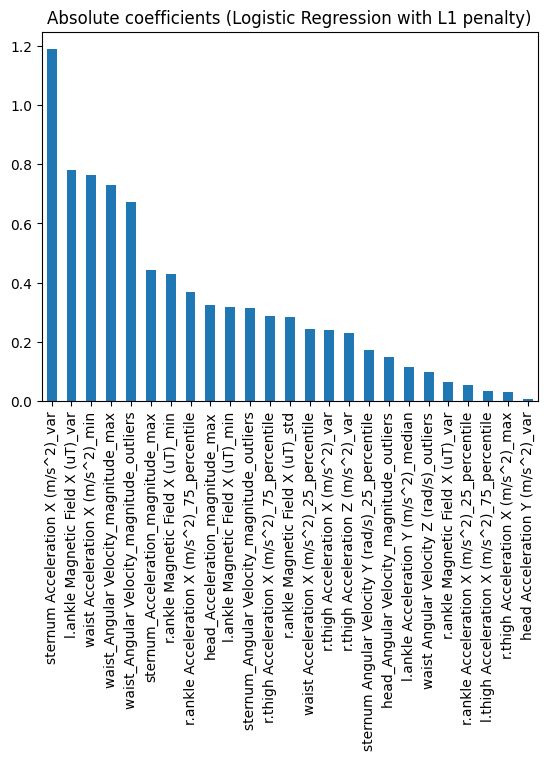

In [12]:
s_coefs = pd.Series(l1_coefs, index=X_train.columns, name='Coefficient')
s_coefs = s_coefs[s_coefs!=0]
s_coefs.abs().sort_values(ascending=False).plot(
    kind='bar',
    title='Absolute coefficients (Logistic Regression with L1 penalty)');

Some highlights:

* 8 out of 25 features (32%) are from the ankles sensors.
* 14 out of 25 features (56%) are acceleration measures.
* 14 out of 25 features (56%) are from measures along the X-axis.
* The 8 most important features come from the ankles, sternum, and waist sensors.